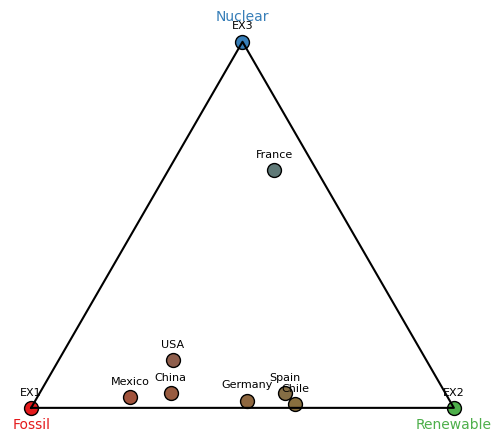

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Country data (Fossil, Renewable, Nuclear)
countries_shares = {
    "EX1": (1., 0., 0.),
    "EX2": (0., 1., 0.),
    "EX3": (0., 0., 1.),
    "Mexico": (0.75, 0.22, 0.03),
    "Spain": (0.38, 0.58, 0.04),
    "Germany": (0.48, 0.50, 0.02),
    "Chile": (0.37, 0.62, 0.01),
    "China": (0.65, 0.31, 0.04),
    "USA": (0.60, 0.27, 0.13),
    "France": (0.10, 0.25, 0.65)
}

# Colors for vertices
base_colors = {
    'fossil': (228, 26, 28),    # red
    'renewable': (77, 175, 74), # green
    'nuclear': (55, 126, 184)   # blue
}

# Colors for vertices
#base_colors = {    'fossil': (255, 0,0),'renewable': (0, 255, 0),'nuclear': (0, 0, 255)}

# Caps for each category
caps = {
    'fossil': 1,#0.85,
    'renewable': 1,#0.70,
    'nuclear': 1,#0.65
}

def ternary_to_rgb_scaled(fossil, renewable, nuclear, colors, caps, gamma=.2):
    # Apply caps
    f = min(fossil, caps['fossil'])
    r = min(renewable, caps['renewable'])
    n = min(nuclear, caps['nuclear'])
    
    # Normalize after caps
    total = f + r + n
    f, r, n = f/total, r/total, n/total
    
    # Non-linear scaling
    f_gamma = f**gamma
    r_gamma = r**gamma
    n_gamma = n**gamma
    
    # Renormalize
    total_gamma = f_gamma + r_gamma + n_gamma
    f_norm, r_norm, n_norm = f_gamma/total_gamma, r_gamma/total_gamma, n_gamma/total_gamma
    
    # Blend colors
    f_color = np.array(colors['fossil'])
    r_color = np.array(colors['renewable'])
    n_color = np.array(colors['nuclear'])
    rgb = f_norm * f_color + r_norm * r_color + n_norm * n_color
    return rgb.astype(int) / 255

# Convert ternary (fossil, renewable, nuclear) to 2D cartesian coords
def ternary_to_cartesian(f, r, n):
    x = 0.5 * (2*r + n) / (f + r + n)
    y = (np.sqrt(3)/2) * n / (f + r + n)
    return x, y

fig, ax = plt.subplots(figsize=(6, 6))

for country, (f, r, n) in countries_shares.items():
    rgb = ternary_to_rgb_scaled(f, r, n, base_colors, caps, gamma=0.5)
    x, y = ternary_to_cartesian(f, r, n)
    ax.scatter(x, y, color=rgb, s=100, edgecolor='k')
    ax.text(x, y + 0.03, country, ha='center', fontsize=8)

# Draw triangle outline
triangle = np.array([[0, 0], [1, 0], [0.5, np.sqrt(3)/2], [0, 0]])
ax.plot(triangle[:,0], triangle[:,1], color='black')

# Vertex labels
ax.text(0, -0.05, "Fossil", ha='center', fontsize=10, color=np.array(base_colors['fossil'])/255)
ax.text(1, -0.05, "Renewable", ha='center', fontsize=10, color=np.array(base_colors['renewable'])/255)
ax.text(0.5, np.sqrt(3)/2 + 0.05, "Nuclear", ha='center', fontsize=10, color=np.array(base_colors['nuclear'])/255)

ax.set_aspect('equal')
ax.axis('off')
plt.show()